# Step-1: Loading the Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import glob 
filePaths = glob.glob("/home/prakhar/Desktop/College/3rdYear/SEM-VI/MinorProject/Datasets/archive-2/*.csv")
df_list = [pd.read_csv(file,low_memory=False) for file in filePaths]
df=pd.concat(df_list,ignore_index=True)
print(df.shape)
print(df.head())

(2830743, 79)
    Destination Port   Flow Duration   Total Fwd Packets  \
0              54865               3                   2   
1              55054             109                   1   
2              55055              52                   1   
3              46236              34                   1   
4              54863               3                   2   

    Total Backward Packets  Total Length of Fwd Packets  \
0                        0                           12   
1                        1                            6   
2                        1                            6   
3                        1                            6   
4                        0                           12   

    Total Length of Bwd Packets   Fwd Packet Length Max  \
0                             0                       6   
1                             6                       6   
2                             6                       6   
3                             6   

In [3]:
df.columns = df.columns.str.strip()
df['Label'].unique()

array(['BENIGN', 'DDoS', 'PortScan', 'Bot', 'Infiltration',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'FTP-Patator', 'SSH-Patator',
       'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye',
       'Heartbleed'], dtype=object)

# Step-2: Pre-Processing

In [4]:
df.dtypes #Viewing Datatype

Destination Port                 int64
Flow Duration                    int64
Total Fwd Packets                int64
Total Backward Packets           int64
Total Length of Fwd Packets      int64
                                ...   
Idle Mean                      float64
Idle Std                       float64
Idle Max                         int64
Idle Min                         int64
Label                           object
Length: 79, dtype: object

In [5]:
is_inf = df.isin([np.inf, -np.inf])

inf_counts = is_inf.sum()

# Filter to show only columns with infinite values
columns_with_inf = inf_counts[inf_counts > 0]
print("Columns with infinite values:\n", columns_with_inf)

nan_counts = df.isnull().sum()

# Filter to show only columns with NaN values
columns_with_nan = nan_counts[nan_counts > 0]
print("\nColumns with NaN values:\n", columns_with_nan)

combined_counts = nan_counts + inf_counts

# Filter to show only columns with any NaN or inf values
columns_with_nan_or_inf = combined_counts[combined_counts > 0]
print("\nColumns with NaN or infinite values:\n", columns_with_nan_or_inf)

duplicate_rows_count = df.duplicated().sum()
print("\nNumber of duplicate rows:", duplicate_rows_count)

Columns with infinite values:
 Flow Bytes/s      1509
Flow Packets/s    2867
dtype: int64

Columns with NaN values:
 Flow Bytes/s    1358
dtype: int64

Columns with NaN or infinite values:
 Flow Bytes/s      2867
Flow Packets/s    2867
dtype: int64

Number of duplicate rows: 308381


In [6]:
df.replace([np.inf, -np.inf], np.nan, inplace=True) #Replacing inf values
df.dropna(inplace=True) #Replacing NaN values
df.drop_duplicates(inplace=True) #Removing duplicates to improve accuracy
category_mapping = {
    'BENIGN': 'BENIGN',
    'Bot': 'BOTNET',
    'DDoS': 'DOS',
    'DoS GoldenEye': 'DOS',
    'DoS Hulk': 'DOS',
    'DoS Slowhttptest': 'DOS',
    'DoS slowloris': 'DOS',
    'FTP-Patator': 'BRUTE_FORCE',
    'SSH-Patator': 'BRUTE_FORCE',
    'Heartbleed': 'WEB_ATTACK',
    'Infiltration': 'WEB_ATTACK',
    'PortScan': 'RECONNAISSANCE',
    'Web Attack � Brute Force': 'WEB_ATTACK',
    'Web Attack � Sql Injection': 'WEB_ATTACK',
    'Web Attack � XSS': 'WEB_ATTACK'
}
#Applying Mapping to simplify labels
df['Label'] =df['Label'].map(category_mapping)

In [7]:
print(df['Label'].value_counts())  # Before encoding

Label
BENIGN            2095057
DOS                321759
RECONNAISSANCE      90694
BRUTE_FORCE          9150
WEB_ATTACK           2190
BOTNET               1948
Name: count, dtype: int64


In [8]:
from sklearn.preprocessing import LabelEncoder #After Encoding
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

In [9]:
print(df['Label'].value_counts())  # Before encoding

Label
0    2095057
3     321759
4      90694
2       9150
5       2190
1       1948
Name: count, dtype: int64


In [10]:
import pandas as pd

# Get class counts
class_counts = df['Label'].value_counts()

# Select classes with more than 5000 samples
selected_classes = class_counts[class_counts > 50000].index.tolist()

# Manually include "WEB_ATTACK" and "BOTNET" if they exist in the dataset
for attack in [1, 5, 2]:
    if attack in df['Label'].values and attack not in selected_classes:
        selected_classes.append(attack)

# Select rows where 'Label' is in selected_classes
selected = df[df['Label'].isin(selected_classes)]

dfs = []
for name in selected_classes:
    df_class = selected[selected['Label'] == name]

    # Downsample if the class has more than 5000 samples
    if len(df_class) > 50000:
        df_class = df_class.sample(n=50000, random_state=0)

    dfs.append(df_class)

# Combine all sampled data
balanced_df = pd.concat(dfs, ignore_index=True)

# Check final class distribution
print(balanced_df['Label'].value_counts())

Label
0    50000
3    50000
4    50000
2     9150
5     2190
1     1948
Name: count, dtype: int64


In [11]:
balanced_df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,53,62874,4,2,116,186,29,29,29.000,0.000000,...,20,0.00000,0.00000,0,0,0.000,0.00000,0,0,0
1,57225,86,1,1,0,0,0,0,0.000,0.000000,...,32,0.00000,0.00000,0,0,0.000,0.00000,0,0,0
2,80,116003861,16,14,440,412,356,0,27.500,87.612784,...,20,46441.09091,31255.09835,140678,36852,9995557.727,14892.00092,10000000,9950679,0
3,443,5683083,8,6,397,3716,216,0,49.625,79.224703,...,20,269399.00000,0.00000,269399,269399,5413681.000,0.00000,5413681,5413681,0
4,53,23652,1,1,48,128,48,48,48.000,0.000000,...,20,0.00000,0.00000,0,0,0.000,0.00000,0,0,0


In [12]:
from imblearn.over_sampling import SMOTE

x = balanced_df.drop('Label', axis=1)
y = balanced_df['Label']

smote = SMOTE(sampling_strategy='auto', random_state=0)
X_upsampled, y_upsampled = smote.fit_resample(x, y)

blnc_data = pd.DataFrame(X_upsampled)
blnc_data['Label'] = y_upsampled
blnc_data = blnc_data.sample(frac=1)

print(blnc_data['Label'].value_counts())
blnc_data.head()

Label
2    50000
4    50000
0    50000
3    50000
1    50000
5    50000
Name: count, dtype: int64


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
212707,22,11686521,22,33,2008,2745,640,0,88.772704,137.021592,...,32,0.0,0.0,0,0,0.0,0.0,0,0,2
244253,22,11479577,19,32,2008,2745,640,0,104.458771,143.314034,...,32,0.0,0.0,0,0,0.0,0.0,0,0,2
224799,21,8518789,9,15,110,188,23,0,12.303894,10.015616,...,32,0.0,0.0,0,0,0.0,0.0,0,0,2
124230,53,25,1,1,0,6,0,0,0.000000,0.000000,...,40,0.0,0.0,0,0,0.0,0.0,0,0,4
26797,58908,48,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0


In [13]:
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
x = blnc_data.drop('Label',axis=1)
y = blnc_data['Label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)
n_components = 20
ipca = IncrementalPCA(n_components=n_components, batch_size=500)
x_pca = ipca.fit_transform(X_scaled) 
print(f"Explained Variance Ratio: {sum(ipca.explained_variance_ratio_):.4f}")
x = x_pca

Explained Variance Ratio: 0.9306


In [16]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,shuffle=True)

# Step-3: DL Algorithms

In [14]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
import tensorflow as tf
import keras
from keras import layers,regularizers,optimizers,callbacks

2025-04-14 23:32:38.528786: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744653758.621412    5534 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744653758.645163    5534 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744653758.817291    5534 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744653758.817324    5534 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744653758.817328    5534 computation_placer.cc:177] computation placer alr

#### Step-3.3: Applying DNN

In [24]:
model = keras.Sequential()
model.add(layers.Input(shape=(x_train.shape[1],)))  # Input layer

model.add(layers.Dense(128, activation='relu'))  # Hidden layer
model.add(layers.Dropout(0.1))  # Dropout layer

model.add(layers.Dense(256, activation='relu'))  # Hidden layer
model.add(layers.Dropout(0.1))  # Dropout layer

model.add(layers.Dense(128, activation='relu'))  # Hidden layer
model.add(layers.Dropout(0.1))  # Dropout layer

model.add(layers.Dense(6, activation='softmax'))  # Output layer

I0000 00:00:1744654216.968713    5534 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2166 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
2025-04-14 23:40:17.417386: W external/local_xla/xla/service/gpu/llvm_gpu_backend/default/nvptx_libdevice_path.cc:40] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  ipykernel_launcher.runfiles/cuda_nvcc
  ipykern/cuda_nvcc
  
  /usr/local/cuda
  /opt/cuda
  /home/prakhar/.conda/envs/minorproject/lib/python3.11/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc
  /home/prakhar/.conda/envs/minorproject/lib/python3.11/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc
  /home/prakhar/.conda/envs/minorproject/lib/python3.11/sit

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,382 (271.02 KB)

 Trainable params: 69,382 (271.02 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
early_stopping = keras.callbacks.EarlyStopping(
    verbose=1, restore_best_weights=True, patience=3)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath="Models/Test/dnn_best.keras", save_best_only=True)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=[
              'accuracy'])  # compiling model

In [19]:
history = model.fit(x_train, y_train, epochs=50, batch_size=32, callbacks=[
          early_stopping, model_checkpoint],validation_data=(x_test,y_test))  # Fitting Model
model.save("Models/Final/DNN.h5")  # Saving the model

Epoch 1/50
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.8610 - loss: 0.4800 - val_accuracy: 0.9613 - val_loss: 0.1247
Epoch 2/50
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9587 - loss: 0.1363 - val_accuracy: 0.9704 - val_loss: 0.0971
Epoch 3/50
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.9680 - loss: 0.1098 - val_accuracy: 0.9723 - val_loss: 0.0855
Epoch 4/50
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9703 - loss: 0.0987 - val_accuracy: 0.9754 - val_loss: 0.0796
Epoch 5/50
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9731 - loss: 0.0885 - val_accuracy: 0.9763 - val_loss: 0.0742
Epoch 6/50
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9745 - loss: 0.0842 - val_accuracy: 0.9775 - val_loss: 0.0693
Epoch 7/50
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9756 - loss: 0.0805 - val_accuracy: 0.9785 - val_loss: 0.0673
Epoch 8/50
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9765 - loss: 0

In [20]:
print(f"Result of Prediction") #Performing Predictions
predictions=model.predict(x=x_test)
print(predictions)
print("predictions shape:", predictions.shape)

Result of Prediction
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 785us/step
[[5.1413081e-03 5.5685832e-13 4.9669165e-05 2.3800954e-05 7.4183496e-05
  9.9471104e-01]
 [4.5988138e-05 4.0788839e-12 9.9995345e-01 1.0171353e-07 6.8175371e-10
  2.9967401e-07]
 [4.1050182e-08 1.7589648e-12 9.9999994e-01 8.9094347e-15 2.0713429e-11
  1.7870275e-10]
 ...
 [2.4306098e-02 9.7478265e-01 6.3705392e-04 1.2872506e-04 4.6925790e-05
  9.8525583e-05]
 [3.0642433e-02 9.6935678e-01 3.6603009e-07 3.5793414e-07 6.8491410e-08
  1.6389685e-09]
 [3.9377706e-08 9.8089004e-31 2.7859466e-11 9.9999994e-01 4.5187054e-09
  6.1621246e-20]]
predictions shape: (75000, 6)


#### Step-3.4: Applying DCNN

In [17]:
x_test.shape
x_train.shape

(225000, 20)

In [23]:
x_train.shape

(225000, 20)

In [18]:
x_train_reshaped = x_train.reshape(
    x_train.shape[0], x_train.shape[1], 1)

x_test_reshaped = x_test.reshape(
    x_test.shape[0], x_test.shape[1], 1)

In [21]:
x_train_reshaped.shape

(225000, 20, 1)

In [22]:
x_test_reshaped.shape

(75000, 20, 1)

In [ ]:
# Create the model as before
model_cnn = keras.Sequential()

model_cnn.add(layers.Input(shape=(x_train_reshaped.shape[1], 1)))
model_cnn.add(layers.Conv1D(128, 20, data_format='channels_last',
                            activation='relu', padding='same'))
model_cnn.add(layers.Conv1D(256, 20, data_format='channels_last',
                            activation='relu', padding='same'))

model_cnn.add(layers.Flatten())

model_cnn.add(layers.Dense(256, activation='relu',
                           kernel_regularizer=keras.regularizers.l1_l2()))

model_cnn.add(layers.Dense(6, activation='softmax'))

W0000 00:00:1743051326.022475   10165 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [22]:
model_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 20, 128)        │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 256)        │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5120)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     1,310,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,970,822 (7.52 MB)

 Trainable params: 1,970,822 (7.52 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
callback = keras.callbacks.EarlyStopping(
    verbose=1, restore_best_weights=True, patience=3)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath="Models/Test/cnn_best.keras", save_best_only=True)
model_cnn.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=[
                  'accuracy'])  # compiling model

In [24]:
history = model_cnn.fit(x_train_reshaped, y_train, epochs=50, batch_size=32, callbacks=[
              early_stopping, model_checkpoint], validation_data=(x_test_reshaped, y_test))  # Fitting Model
model_cnn.save("Models/Final/CNN.h5")  # Saving the model

Epoch 1/50
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 193s 27ms/step - accuracy: 0.9325 - loss: 0.2574 - val_accuracy: 0.9743 - val_loss: 0.0879
Epoch 2/50
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 186s 26ms/step - accuracy: 0.9738 - loss: 0.0875 - val_accuracy: 0.9779 - val_loss: 0.0728
Epoch 3/50
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 182s 26ms/step - accuracy: 0.9768 - loss: 0.0754 - val_accuracy: 0.9794 - val_loss: 0.0646
Epoch 4/50
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 182s 26ms/step - accuracy: 0.9789 - loss: 0.0685 - val_accuracy: 0.9792 - val_loss: 0.0628
Epoch 5/50
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 182s 26ms/step - accuracy: 0.9804 - loss: 0.0627 - val_accuracy: 0.9813 - val_loss: 0.0630
Epoch 6/50
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 181s 26ms/step - accuracy: 0.9809 - loss: 0.0620 - val_accuracy: 0.9825 - val_loss: 0.0584
Epoch 7/50
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 188s 27ms/step - accuracy: 0.9823 - loss: 0.0574 - val_accuracy: 0.9819 - val_loss: 0.0563
Epoch 8/50
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 191s 27ms/step - accuracy: 

In [25]:
print(f"Result of Prediction")  # Performing Predictions
predictions = model_cnn.predict(x=x_test_reshaped)
print(predictions)
print("predictions shape:", predictions.shape)

Result of Prediction
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
[[4.19297162e-03 3.36985018e-09 5.80093656e-05 4.91282553e-05
  2.64665752e-04 9.95435238e-01]
 [9.48653673e-04 3.60830615e-14 9.99051154e-01 1.16293222e-07
  1.02613136e-07 5.52617196e-09]
 [2.90783646e-06 1.38562962e-13 9.99997079e-01 2.71710932e-10
  4.50527150e-11 7.59171281e-10]
 ...
 [2.12407820e-02 9.78705466e-01 5.27356769e-06 2.54320512e-05
  4.12782674e-06 1.90565206e-05]
 [7.71389110e-03 9.92285788e-01 1.59661673e-09 2.73120946e-07
  6.74596521e-08 3.53578056e-10]
 [4.34548439e-11 0.00000000e+00 1.82297420e-34 9.99999940e-01
  2.23466255e-19 0.00000000e+00]]
predictions shape: (75000, 6)


In [26]:
print(f"Results of Testing")  # Testing the model
model_cnn.evaluate(x_test_reshaped, y_test)

Results of Testing
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9878 - loss: 0.0394


[0.04063998907804489, 0.9874133467674255]

# Step-4: Loading and Evaluating Model

In [25]:
model =  keras.models.load_model('Models/Final/DNN.h5')
model_2 = keras.models.load_model('Models/Final/CNN.h5')

#### Step-4.1: DNN

In [17]:
y_pred = model.predict(x_test) #For DNN
y_pred_class = np.argmax(y_pred, axis=1)

# Print classification report
print(classification_report(y_test, y_pred_class))

2344/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
              precision    recall  f1-score   support

           0       0.95      0.94      0.95     12595
           1       0.98      0.95      0.97     12537
           2       0.99      0.98      0.99     12460
           3       0.97      1.00      0.98     12550
           4       0.98      1.00      0.99     12418
           5       0.98      0.99      0.98     12440

    accuracy                           0.98     75000
   macro avg       0.98      0.98      0.98     75000
weighted avg       0.98      0.98      0.98     75000



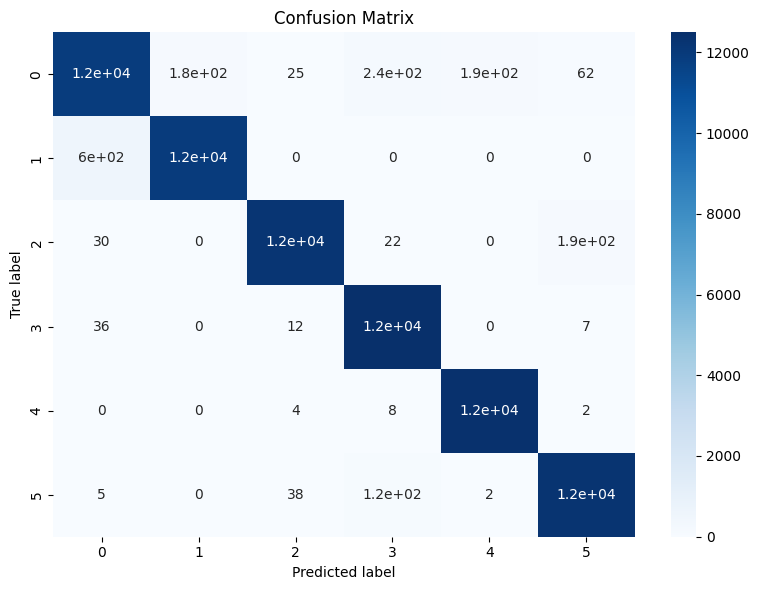

In [18]:
# Compute ROC curve
# False Positive Rate, True Positive Rate
conf_mtr = confusion_matrix(y_true=y_test, y_pred=y_pred_class)
# Creating a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mtr, annot=True, cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

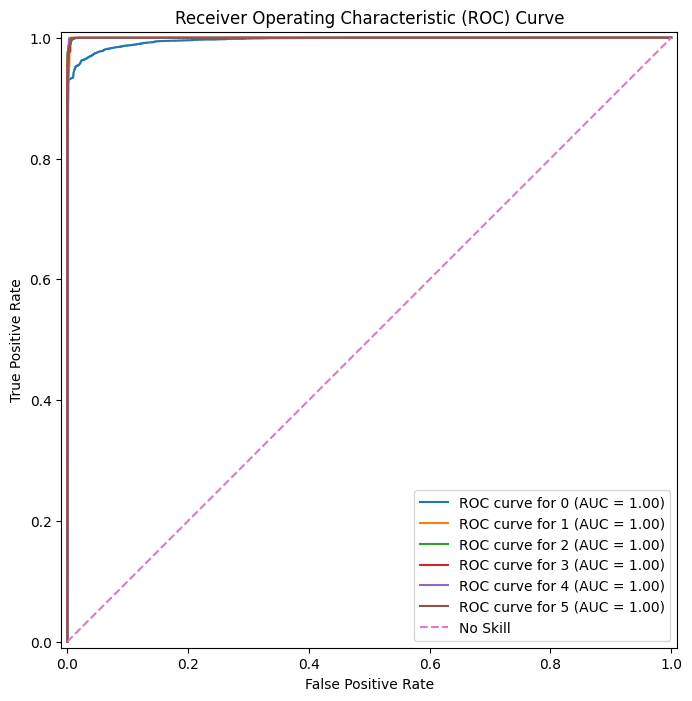

In [19]:
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(lb.classes_):
    RocCurveDisplay.from_predictions(
        y_test_bin[:, i],
        y_pred[:, i],  # Use probability scores for class i
        name=f'ROC curve for {class_name}',
        ax=plt.gca()
    )


plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

#### Step-4.2: CNN

In [22]:
y_pred = model_2.predict(x_test_reshaped)  # For CNN
y_pred_class = np.argmax(y_pred, axis=1)

# Print classification report
print(classification_report(y_test, y_pred_class))

2344/2344 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     12595
           1       0.99      1.00      0.99     12537
           2       0.99      0.98      0.99     12460
           3       0.98      0.97      0.98     12550
           4       0.99      1.00      0.99     12418
           5       0.98      0.99      0.98     12440

    accuracy                           0.98     75000
   macro avg       0.98      0.98      0.98     75000
weighted avg       0.98      0.98      0.98     75000



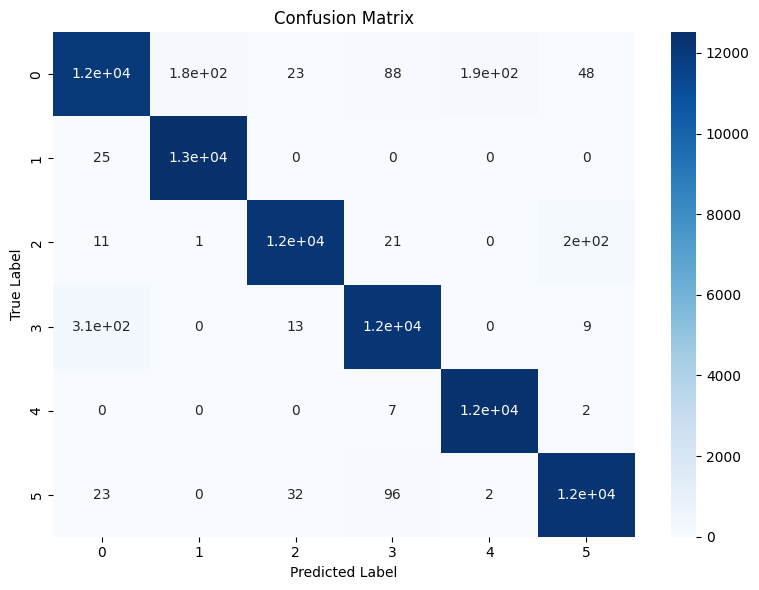

In [23]:
conf_mtr = confusion_matrix(y_true=y_test, y_pred=y_pred_class)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mtr, annot=True, cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

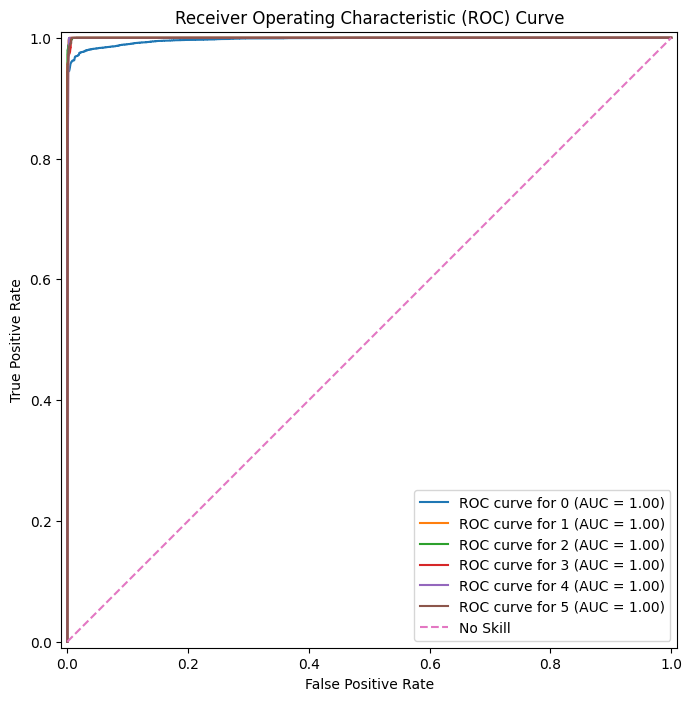

In [24]:
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(lb.classes_):
    RocCurveDisplay.from_predictions(
        y_test_bin[:, i],
        y_pred[:, i],  # Use probability scores for class i
        name=f'ROC curve for {class_name}',
        ax=plt.gca()
    )


plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()